# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Device: Tesla T4


In [2]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    print(f"Created directory: {sample_dir}")

Created directory: samples


# HPT Config

In [3]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100
batch_size = 100

print("=" * 70)
print("GAN HYPERPARAMETER CONFIGURATION")
print("=" * 70)
print(f"Latent Space Dimension:    {latent_size}")
print(f"Hidden Layer Size:         {hidden_size}")
print(f"Image Size (flattened):    {image_size} ({int(image_size**0.5)}×{int(image_size**0.5)})")
print(f"Training Epochs:           {num_epochs}")
print(f"Batch Size:                {batch_size}")
print("=" * 70)

GAN HYPERPARAMETER CONFIGURATION
Latent Space Dimension:    64
Hidden Layer Size:         256
Image Size (flattened):    784 (28×28)
Training Epochs:           100
Batch Size:                100


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nCompute Device: {device}")
if device.type == 'cuda':
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Compute Device: cuda
GPU Memory Available: 15.83 GB


# Data Preparation and Loading

In [5]:
def load_mnist_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5],
            std=[0.5]
        )
    ])

    mnist = torchvision.datasets.FashionMNIST(
        root='./data/',
        train=True,
        transform=transform,
        download=True
    )

    data_loader = torch.utils.data.DataLoader(
        dataset=mnist,
        batch_size=batch_size,
        shuffle=True
    )

    print(f"\nDataset loaded successfully!")
    print(f"Total training images: {len(mnist)}")
    print(f"Batches per epoch: {len(data_loader)}")
    print(f"Image shape: (1, 28, 28)")

    return data_loader

In [6]:
data_loader = load_mnist_data(batch_size)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.53MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 136kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.54MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.3MB/s]


Dataset loaded successfully!
Total training images: 60000
Batches per epoch: 600
Image shape: (1, 28, 28)


# Model Architecture Design

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

generator = Generator(latent_size, hidden_size, image_size).to(device)

print("\n" + "=" * 70)
print("GENERATOR ARCHITECTURE")
print("=" * 70)
print(generator)
print("=" * 70)
print(f"Total Parameters: {sum(p.numel() for p in generator.parameters()):,}")
print("=" * 70)


GENERATOR ARCHITECTURE
Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)
Total Parameters: 283,920


In [8]:
test_noise = torch.randn(1, latent_size).to(device)
test_output = generator(test_noise)
print(f"\nGenerator Test:")
print(f"Input shape:  {test_noise.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min().item():.3f}, {test_output.max().item():.3f}]")


Generator Test:
Input shape:  torch.Size([1, 64])
Output shape: torch.Size([1, 784])
Output range: [-0.234, 0.211]


In [9]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator(image_size, hidden_size).to(device)

print("\n" + "=" * 70)
print("DISCRIMINATOR ARCHITECTURE")
print("=" * 70)
print(discriminator)
print("=" * 70)
print(f"Total Parameters: {sum(p.numel() for p in discriminator.parameters()):,}")
print("=" * 70)


DISCRIMINATOR ARCHITECTURE
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Total Parameters: 267,009


In [10]:
test_image = torch.randn(1, image_size).to(device)
test_classification = discriminator(test_image)
print(f"\nDiscriminator Test:")
print(f"Input shape:  {test_image.shape}")
print(f"Output shape: {test_classification.shape}")
print(f"Output value: {test_classification.item():.4f} (probability of being real)")


Discriminator Test:
Input shape:  torch.Size([1, 784])
Output shape: torch.Size([1, 1])
Output value: 0.5186 (probability of being real)


# Training Configuration

In [11]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

print("\nOptimization Configuration:")
print(f"Loss Function: Binary Cross-Entropy")
print(f"Optimizer: Adam")
print(f"Learning Rate: 0.0002")
print(f"Separate optimizers for D and G")


Optimization Configuration:
Loss Function: Binary Cross-Entropy
Optimizer: Adam
Learning Rate: 0.0002
Separate optimizers for D and G


In [13]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Adversarial Training Loop

In [14]:
total_step = len(data_loader)
d_losses = []
g_losses = []

print("\n" + "=" * 70)
print("STARTING GAN TRAINING")
print("=" * 70)
print(f"Total Epochs: {num_epochs}")
print(f"Steps per Epoch: {total_step}")
print(f"Total Training Steps: {num_epochs * total_step}")
print("=" * 70 + "\n")

for epoch in range(num_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0

    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = generator(z)

        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    d_losses.append(epoch_d_loss / total_step)
    g_losses.append(epoch_g_loss / total_step)
    if (epoch + 1) % 1 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        torchvision.utils.save_image(
            denorm(fake_images),
            os.path.join(sample_dir, f'fake_images-{epoch+1}.png')
        )

print("\n" + "=" * 70)
print("TRAINING COMPLETED")
print("=" * 70)
print(f"Final D Loss: {d_losses[-1]:.4f}")
print(f"Final G Loss: {g_losses[-1]:.4f}")
print("=" * 70)


STARTING GAN TRAINING
Total Epochs: 100
Steps per Epoch: 600
Total Training Steps: 60000

Epoch [1/100], Step [200/600], D_loss: 0.0939, G_loss: 3.4872, D(x): 0.98, D(G(z)): 0.07
Epoch [1/100], Step [400/600], D_loss: 0.1875, G_loss: 4.1037, D(x): 0.98, D(G(z)): 0.15
Epoch [1/100], Step [600/600], D_loss: 0.1243, G_loss: 3.1490, D(x): 0.97, D(G(z)): 0.09
Epoch [2/100], Step [200/600], D_loss: 0.0859, G_loss: 4.1725, D(x): 0.96, D(G(z)): 0.03
Epoch [2/100], Step [400/600], D_loss: 0.1336, G_loss: 3.6572, D(x): 0.96, D(G(z)): 0.06
Epoch [2/100], Step [600/600], D_loss: 0.1311, G_loss: 5.0218, D(x): 0.96, D(G(z)): 0.05
Epoch [3/100], Step [200/600], D_loss: 0.3203, G_loss: 3.8273, D(x): 0.92, D(G(z)): 0.14
Epoch [3/100], Step [400/600], D_loss: 0.2821, G_loss: 3.7631, D(x): 0.95, D(G(z)): 0.17
Epoch [3/100], Step [600/600], D_loss: 0.0350, G_loss: 5.5748, D(x): 0.98, D(G(z)): 0.02
Epoch [4/100], Step [200/600], D_loss: 0.0760, G_loss: 5.3579, D(x): 0.98, D(G(z)): 0.05
Epoch [4/100], Step

In [15]:
print(f"\nTraining Statistics:")
print(f"Epochs completed: {len(d_losses)}")
print(f"Average D Loss: {sum(d_losses)/len(d_losses):.4f}")
print(f"Average G Loss: {sum(g_losses)/len(g_losses):.4f}")


Training Statistics:
Epochs completed: 100
Average D Loss: 0.7398
Average G Loss: 2.0425


# Model Evaluation and Plots

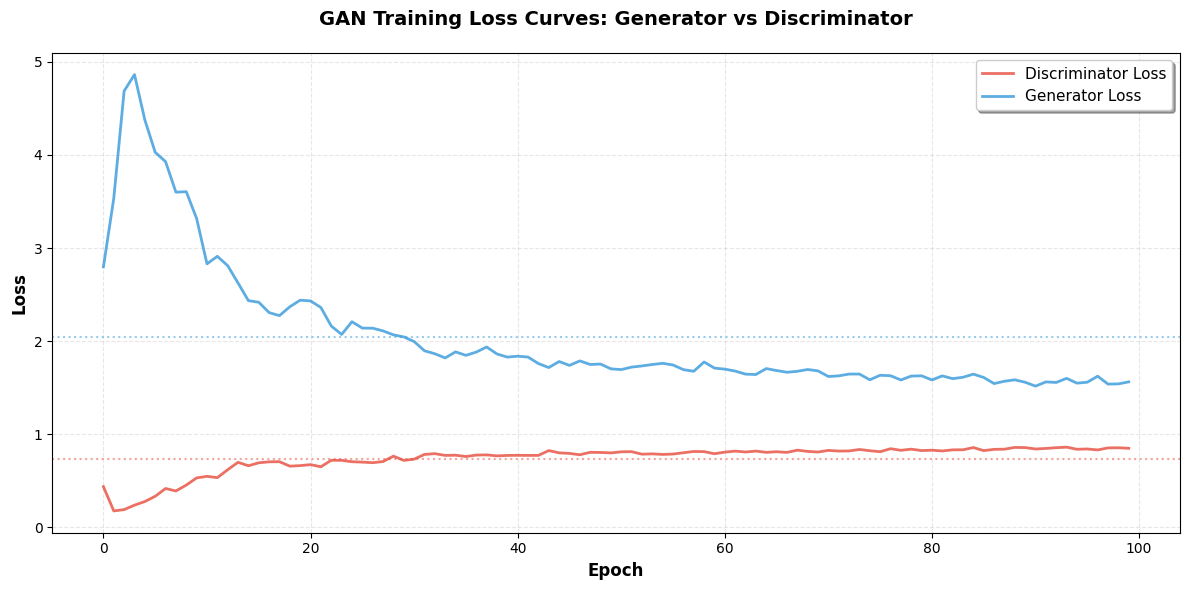


LOSS ANALYSIS
Final D Loss:     0.8501
Final G Loss:     1.5636
Average D Loss:   0.7398
Average G Loss:   2.0425
Loss Ratio (G/D): 1.8394


In [16]:
plt.figure(figsize=(12, 6))

plt.plot(d_losses, label='Discriminator Loss',
         linewidth=2, color='#e74c3c', alpha=0.8)

plt.plot(g_losses, label='Generator Loss',
         linewidth=2, color='#3498db', alpha=0.8)

plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('GAN Training Loss Curves: Generator vs Discriminator',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')

plt.axhline(y=sum(d_losses)/len(d_losses), color='#e74c3c',
            linestyle=':', alpha=0.5, label=f'Avg D Loss: {sum(d_losses)/len(d_losses):.3f}')
plt.axhline(y=sum(g_losses)/len(g_losses), color='#3498db',
            linestyle=':', alpha=0.5, label=f'Avg G Loss: {sum(g_losses)/len(g_losses):.3f}')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("LOSS ANALYSIS")
print("=" * 70)
print(f"Final D Loss:     {d_losses[-1]:.4f}")
print(f"Final G Loss:     {g_losses[-1]:.4f}")
print(f"Average D Loss:   {sum(d_losses)/len(d_losses):.4f}")
print(f"Average G Loss:   {sum(g_losses)/len(g_losses):.4f}")
print(f"Loss Ratio (G/D): {g_losses[-1]/d_losses[-1]:.4f}")
print("=" * 70)

In [17]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

print("\n" + "=" * 70)
print("MODEL WEIGHTS SAVED")
print("=" * 70)
print("Generator weights saved to: generator.pth")
print("Discriminator weights saved to: discriminator.pth")
print("=" * 70)


MODEL WEIGHTS SAVED
Generator weights saved to: generator.pth
Discriminator weights saved to: discriminator.pth



REAL VS GENERATED IMAGE COMPARISON


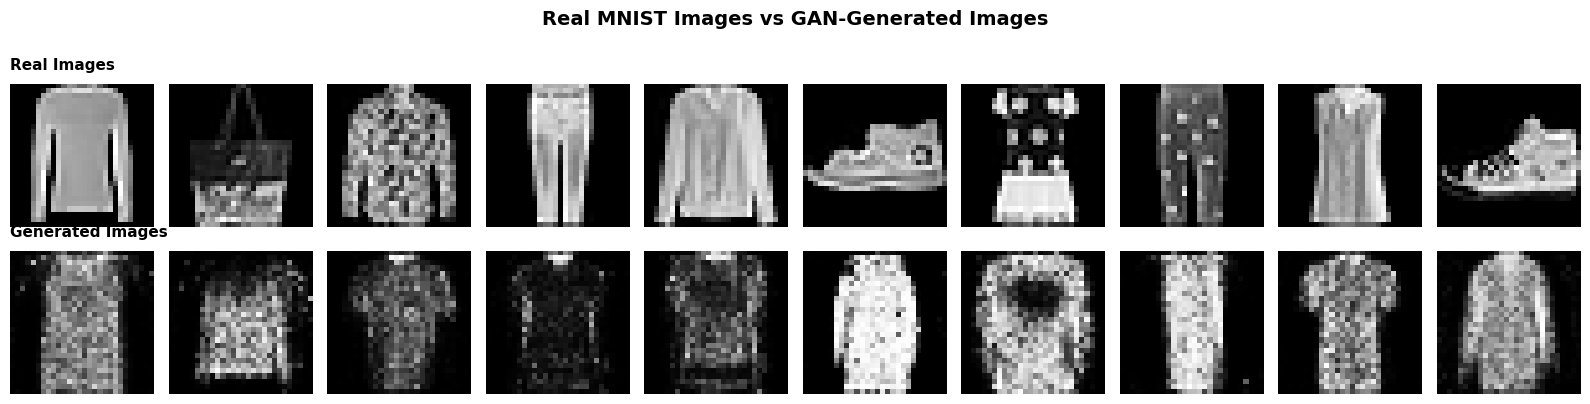


Visual Comparison Complete
Top Row:    Real MNIST training images
Bottom Row: GAN-generated synthetic images


In [18]:
fig, axes = plt.subplots(2, 10, figsize=(16, 4))

print("\n" + "=" * 70)
print("REAL VS GENERATED IMAGE COMPARISON")
print("=" * 70)

real_batch = next(iter(data_loader))
real_images = real_batch[0][:10]

for i in range(10):
    axes[0, i].imshow(real_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Real Images', fontweight='bold',
                              loc='left', fontsize=11, pad=10)

generator.eval()
with torch.no_grad():
    z = torch.randn(10, latent_size).to(device)
    fake_images = generator(z)
    fake_images = fake_images.view(-1, 1, 28, 28)
    fake_images = denorm(fake_images).cpu()

for i in range(10):
    axes[1, i].imshow(fake_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Generated Images', fontweight='bold',
                              loc='left', fontsize=11, pad=10)

plt.suptitle('Real MNIST Images vs GAN-Generated Images',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

generator.train()

print("\nVisual Comparison Complete")
print("Top Row:    Real MNIST training images")
print("Bottom Row: GAN-generated synthetic images")
print("=" * 70)